In [23]:
import pandas as pd
import tensorflow as tf
from transformers import RobertaTokenizer, TFRobertaModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [33]:
data = pd.read_csv("/Users/withmocha/Desktop/DATA/BOAZ/미니 프로젝트 1/data/main data/WELFake_Dataset.csv")
data.dropna(axis=0,inplace=True)
data.drop(data.columns[0], axis=1, inplace=True)
data['title'] = data['title'] + data['text']
data

title  \
0      LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
2      UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3      Bobby Jindal, raised Hindu, uses story of Chri...   
4      SATAN 2: Russia unvelis an image of its terrif...   
5      About Time! Christian Group Sues Amazon and SP...   
...                                                  ...   
72129  Russians steal research on Trump in hack of U....   
72130   WATCH: Giuliani Demands That Democrats Apolog...   
72131  Migrants Refuse To Leave Train At Refugee Camp...   
72132  Trump tussle gives unpopular Mexican leader mu...   
72133  Goldman Sachs Endorses Hillary Clinton For Pre...   

                                                    text  label  
0      No comment is expected from Barack Obama Membe...      1  
2       Now, most of the demonstrators gathered last ...      1  
3      A dozen politically active pastors came here f...      0  
4      The RS-28 Sarmat missile, dubbed Satan 2, will...      1  
5      All we can say on this one is it s about time ...      1  
...                                                  ...    ...  
72129  WASHINGTON (Reuters) - Hackers believed to be ...      0  
72130  You know, because in fantasyland Republicans n...      1  
72131  Migrants Refuse To Leave Train At Refugee Camp...      0  
72132  MEXICO CITY (Reuters) - Donald Trump’s combati...      0  
72133  Goldman Sachs Endorses Hillary Clinton For Pre...      1  

[71537 rows x 3 columns]

In [34]:
X = pd.DataFrame(data=data['title'])
Y = pd.DataFrame(data=data['label'])

In [35]:
X.iloc[1,0]

'UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MOST CHARLOTTE RIOTERS WERE “PEACEFUL” PROTESTERS…In Her Home State Of North Carolina [VIDEO] Now, most of the demonstrators gathered last night were exercising their constitutional and protected right to peaceful protest in order to raise issues and create change.    Loretta Lynch aka Eric Holder in a skirt'

In [36]:
Y

label
0          1
2          1
3          0
4          1
5          1
...      ...
72129      0
72130      1
72131      0
72132      0
72133      1

[71537 rows x 1 columns]

In [37]:
texts = X['title'].tolist()
labels = Y['label'].tolist()
texts = [str(text) if pd.notna(text) else "" for text in texts]

In [38]:
texts

['LAW ENFORCEMENT ON HIGH ALERT Following Threats Against Cops And Whites On 9-11By #BlackLivesMatter And #FYF911 Terrorists [VIDEO]No comment is expected from Barack Obama Members of the #FYF911 or #FukYoFlag and #BlackLivesMatter movements called for the lynching and hanging of white people and cops. They encouraged others on a radio show Tuesday night to  turn the tide  and kill white people and cops to send a message about the killing of black people in America.One of the F***YoFlag organizers is called  Sunshine.  She has a radio blog show hosted from Texas called,  Sunshine s F***ing Opinion Radio Show. A snapshot of her #FYF911 @LOLatWhiteFear Twitter page at 9:53 p.m. shows that she was urging supporters to  Call now!! #fyf911 tonight we continue to dismantle the illusion of white Below is a SNAPSHOT Twitter Radio Call Invite   #FYF911The radio show aired at 10:00 p.m. eastern standard time.During the show, callers clearly call for  lynching  and  killing  of white people.A 2:3

In [39]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, shuffle=True)

In [40]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [41]:
def encode_data(texts, tokenizer, max_length=128):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            max_length=max_length,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            return_attention_mask=True,
            return_tensors='tf'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return tf.concat(input_ids, axis=0), tf.concat(attention_masks, axis=0)

In [42]:
train_input_ids, train_attention_masks = encode_data(train_texts, tokenizer)
val_input_ids, val_attention_masks = encode_data(val_texts, tokenizer)

In [43]:
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [45]:
def create_transformer_input(input_ids, attention_masks, batch_size=32):
    def gen():
        for i in range(0, len(input_ids), batch_size):
            yield input_ids[i:i + batch_size], attention_masks[i:i + batch_size]

    dataset = tf.data.Dataset.from_generator(
        gen,
        output_signature=(tf.TensorSpec(shape=(None, input_ids.shape[1]), dtype=tf.int32),
                          tf.TensorSpec(shape=(None, attention_masks.shape[1]), dtype=tf.int32))
    )

    features = []
    for batch_input_ids, batch_attention_masks in dataset:
        outputs = roberta_model(batch_input_ids, attention_mask=batch_attention_masks)
        features.append(outputs.last_hidden_state)

    return tf.concat(features, axis=0)

In [46]:
train_features = create_transformer_input(train_input_ids, train_attention_masks)
val_features = create_transformer_input(val_input_ids, val_attention_masks)

: 

In [ ]:
val_features

In [ ]:
train_features

In [16]:
input_layer = tf.keras.layers.Input(shape=(train_features.shape[1], train_features.shape[2]), dtype=tf.float32)
lstm_layer = tf.keras.layers.LSTM(32, return_sequences=False)(input_layer)
dropout_layer = tf.keras.layers.Dropout(0.5)(lstm_layer)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(dropout_layer)

model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 768)]        0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                102528    
                                                                 
 dropout_39 (Dropout)        (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 102561 (400.63 KB)
Trainable params: 102561 (400.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
import numpy as np

train_labels = np.array(train_labels)
val_labels = np.array(val_labels)


EPOCHS = 50
BATCH_SIZE = 64

history = model.fit(
    train_features,
    train_labels,
    validation_data=(val_features, val_labels),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)


Epoch 1/50
902/902 [==============================] - 60s 65ms/step - loss: 0.5680 - accuracy: 0.7128 - val_loss: 0.3533 - val_accuracy: 0.8880
Epoch 2/50
902/902 [==============================] - 56s 63ms/step - loss: 0.2675 - accuracy: 0.9169 - val_loss: 0.1999 - val_accuracy: 0.9380
Epoch 3/50
902/902 [==============================] - 79s 88ms/step - loss: 0.2060 - accuracy: 0.9388 - val_loss: 0.1666 - val_accuracy: 0.9493
Epoch 4/50
902/902 [==============================] - 66s 73ms/step - loss: 0.1787 - accuracy: 0.9470 - val_loss: 0.1452 - val_accuracy: 0.9560
Epoch 5/50
902/902 [==============================] - 87s 97ms/step - loss: 0.1597 - accuracy: 0.9540 - val_loss: 0.1314 - val_accuracy: 0.9599
Epoch 6/50
902/902 [==============================] - 65s 72ms/step - loss: 0.1408 - accuracy: 0.9594 - val_loss: 0.1166 - val_accuracy: 0.9653
Epoch 7/50
902/902 [==============================] - 65s 72ms/step - loss: 0.1262 - accuracy: 0.9638 - val_loss: 0.1049 - val_accuracy:

451/451 [==============================] - 6s 11ms/step


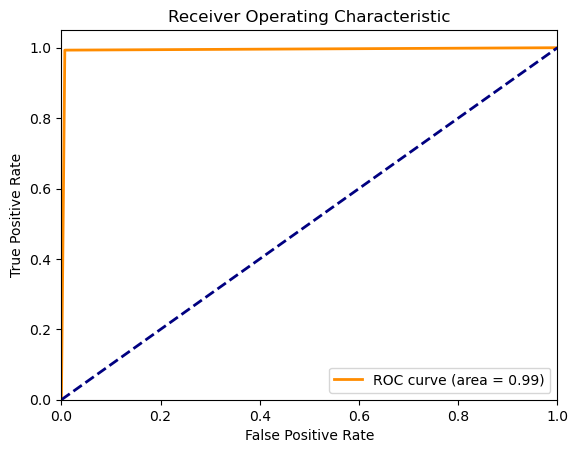

In [18]:
val_pred = model.predict(val_features)
val_pred = (val_pred > 0.5).astype(int)

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, accuracy_score

fpr, tpr, _ = roc_curve(val_labels, val_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

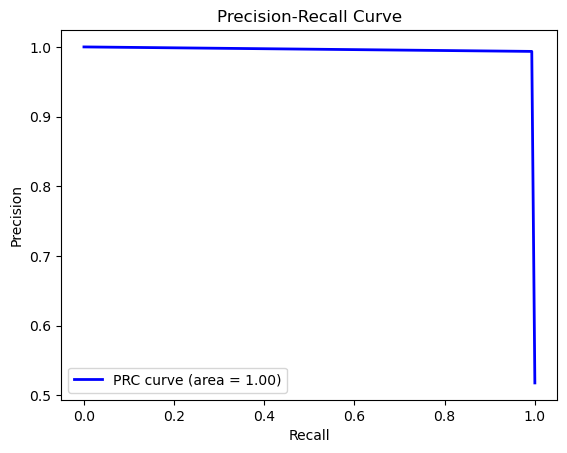

In [19]:
precision, recall, _ = precision_recall_curve(val_labels, val_pred)
prc_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='PRC curve (area = %0.2f)' % prc_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

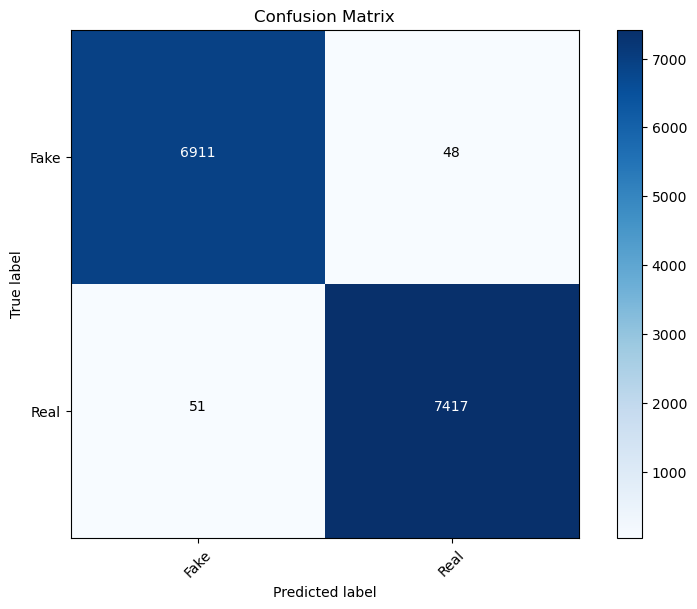

In [20]:
import itertools

conf_matrix = confusion_matrix(val_labels, val_pred)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Fake', 'Real'], rotation=45)
plt.yticks(tick_marks, ['Fake', 'Real'])

thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [21]:
accuracy = accuracy_score(val_labels, val_pred)
print('Accuracy Score:', accuracy)

Accuracy Score: 0.9931378665003119


In [22]:
model.save("LSTM model.keras")